<a href="https://colab.research.google.com/github/zubiamansoor/project_3/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision
!unzip dataset-resized.zip

In [12]:
import torch
torch.cuda.is_available()

True

In [13]:
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets

In [14]:
import os.path as osp
import os

import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from __future__ import print_function
from PIL import Image
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import math

from skimage.transform import resize
import scipy


np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class Dataset_Gary(Dataset):

	def __init__(self, root, fold="train",
				 transform=None, target_transform=None):
		
		fold = fold.lower()

		self.train = False
		self.test = False
		self.val = False

		if fold == "train":
			self.train = True
		elif fold == "test":
			self.test = True
		elif fold == "val":
			self.val = True
		else:
			raise RuntimeError("Not train-val-test")


		self.root = os.path.expanduser(root)
		self.transform = transform
		self.target_transform = target_transform

		fpath = self.root

		# now load the picked numpy arrays
		self.data = []
		if self.train:
			self.datalist_dir = os.path.join(self.root, 'train_list.txt')
		if self.val:
			self.datalist_dir = os.path.join(self.root, 'val_list.txt')
		if self.test:
			self.datalist_dir = os.path.join(self.root, 'test_list.txt')

		with open(self.datalist_dir, 'r') as f:
			for line in f:
				if line[0] == '#' or len(line.strip()) == 0:
					continue
				params = line.strip().split()
				self.data.append({
					'file_name' : params[0],
					'label' : params[1],})

	def __getitem__(self, index):
		label = self.data[index]['label']
		if label == 'cardboard':
			target = 0
		if label == 'glass':
			target = 1
		if label == 'metal':
			target = 2
		if label == 'paper':
			target = 3
		if label == 'plastic':
			target = 4
		if label == 'trash':
			target = 5
		img = plt.imread(osp.join(self.root, self.data[index]['label'], self.data[index]['file_name']))

		# doing this so that it is consistent with all other datasets
		# to return a PIL Image
		img = Image.fromarray(img)

		if self.transform is not None:
			img = self.transform(img)

		if self.target_transform is not None:
			target = self.target_transform(target)

		return img, target

	def __len__(self):
		return len(self.data)



In [92]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained=True)

    #VGG
    #self.resnet18 = models.vgg19(pretrained=True)
    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    
    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    #self.resnet18.fc =  nn.Sequential(nn.Dropout(p=0.5),nn.Linear(num_feats,num_classes))
    self.resnet18.fc =  nn.Linear(num_feats,num_classes)

    #VGG19  
    #self.resnet18 = nn.Sequential(self.resnet18,nn.Linear(1000,num_classes))

  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18.forward(x)
    return x


In [102]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  
  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    
    #forward
    outputs = model.forward(images)
    
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']
  
  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))

  return epoch_loss, epoch_acc


In [103]:
import sklearn.metrics as metric

def test(model, criterion, repeats=2):
  model.eval()
  
  test_loss = 0.0
  test_acc = 0.0
  f1_score = 0.0
  f1_score_w = 0.0
  conf_mat = np.zeros([len(class_names),len(class_names)])
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)
        _, preds = torch.max(outputs.data, 1)

        predlabels = preds.cpu().numpy()
        labels_num = labels.cpu().numpy()
        for ind,label in enumerate(labels_num):
          conf_mat[label,predlabels[ind]] = conf_mat[label,predlabels[ind]] + 1
        

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()
          
        f1_score += metric.f1_score(labels_num, predlabels,labels=[0,1,2,3,4,5], average='weighted', zero_division='warn')
        f1_score_w += metric.f1_score(labels_num, predlabels,labels=[0,1,2,3,4,5], average='macro', zero_division='warn')

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)
    f1_score /= (dataset_sizes['test']*repeats)


    print('Test Loss: %.4f Test Accuracy %.4f Weighted: %.4f Macro: %.4f' % (test_loss, test_acc, f1_score, f1_score_w))
    return test_loss, test_acc, conf_mat


def val(model, criterion, repeats=2):
  model.eval()
  
  test_loss = 0.0
  test_acc = 0.0
  
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['val']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['val']*repeats)
    test_acc /= (dataset_sizes['val']*repeats)

    print('Val Loss: %.4f Val Accuracy %.4f' % (test_loss, test_acc))

    return test_loss, test_acc

In [104]:
#TODO: Vary Hyperparams

NUM_EPOCHS = 25
LEARNING_RATE = 0.001 
BATCH_SIZE = 10
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

root_path = 'dataset/' #If your data is in a different folder, set the path accodordingly

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(384),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets_train = Dataset_Gary(root_path, fold="train",
				 transform=data_transforms['train'], target_transform=None)

image_datasets_val = Dataset_Gary(root_path, fold="val",
				 transform=data_transforms['test'], target_transform=None)

image_datasets_test = Dataset_Gary(root_path, fold="test",
				 transform=data_transforms['test'], target_transform=None)

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch

dataloader_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
            
dataloader_val = torch.utils.data.DataLoader(image_datasets_val, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)

dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)

dataloaders = {'train': dataloader_train, 'test': dataloader_test, 'val':dataloader_val}

dataset_size_train = len(image_datasets_train)
dataset_size_val = len(image_datasets_val)
dataset_size_test = len(image_datasets_test)

dataset_sizes = {'train': dataset_size_train, 'test': dataset_size_test, 'val':dataset_size_val}

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9 , weight_decay=1e-3)

weightlist = [1,1,1,1,1,4]
weightlist = torch.Tensor(weightlist)
weightlist = weightlist.cuda()
criterion = nn.CrossEntropyLoss(weight = weightlist)

train_loss_list =[]
train_acc_list = []
val_loss_list =[]
val_acc_list = []

#Begin Train
for epoch in range(NUM_EPOCHS):
  t1,t2 = train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  train_loss_list.append(t1)
  train_acc_list.append(t2)
  if (epoch+1) % 5 == 0:
    t1,t2 = val(model, criterion)
    val_loss_list.append(t1)
    val_acc_list.append(t2)
  
print("Finished Training")
print("-"*10)

TRAINING Epoch 1/25 Loss 0.1043 Accuracy 0.6131
TRAINING Epoch 2/25 Loss 0.0595 Accuracy 0.7969
TRAINING Epoch 3/25 Loss 0.0428 Accuracy 0.8512
TRAINING Epoch 4/25 Loss 0.0353 Accuracy 0.8716
TRAINING Epoch 5/25 Loss 0.0300 Accuracy 0.8903
Val Loss: 0.0412 Val Accuracy 0.8417
TRAINING Epoch 6/25 Loss 0.0271 Accuracy 0.9112
TRAINING Epoch 7/25 Loss 0.0265 Accuracy 0.9191
TRAINING Epoch 8/25 Loss 0.0180 Accuracy 0.9355
TRAINING Epoch 9/25 Loss 0.0160 Accuracy 0.9446
TRAINING Epoch 10/25 Loss 0.0128 Accuracy 0.9610
Val Loss: 0.0284 Val Accuracy 0.8865
TRAINING Epoch 11/25 Loss 0.0121 Accuracy 0.9576
TRAINING Epoch 12/25 Loss 0.0107 Accuracy 0.9638
TRAINING Epoch 13/25 Loss 0.0113 Accuracy 0.9587
TRAINING Epoch 14/25 Loss 0.0079 Accuracy 0.9729
TRAINING Epoch 15/25 Loss 0.0086 Accuracy 0.9723
Val Loss: 0.0201 Val Accuracy 0.9446
TRAINING Epoch 16/25 Loss 0.0074 Accuracy 0.9785
TRAINING Epoch 17/25 Loss 0.0060 Accuracy 0.9847
TRAINING Epoch 18/25 Loss 0.0068 Accuracy 0.9762
TRAINING Epoch 1

In [121]:
t1,t2,conf_mat = test(model, criterion)
print('Conf Mat\n',conf_mat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Test Loss: 0.0340 Test Accuracy 0.9105 Weighted: 0.0913 Macro: 53.9973
Conf Mat
 [[112.   0.   4.   6.   0.   0.]
 [  0. 136.   6.   0.   6.   0.]
 [  0.   6. 116.   0.   0.   0.]
 [  2.   0.  10. 190.   0.   6.]
 [  0.   0.   8.   4. 120.   2.]
 [  0.   4.   2.   0.   2.  18.]]


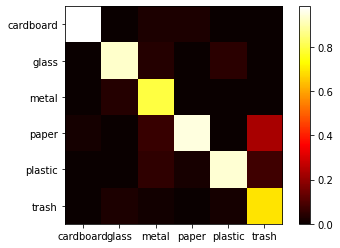

In [127]:
for i in range(6):
  conf_mat[:,i] = conf_mat[:,i]/sum(conf_mat[:,i])

plt.imshow(conf_mat, cmap='hot')

plt.xticks([0,1,2,3,4,5],class_names)
plt.yticks([0,1,2,3,4,5],class_names)
plt.colorbar()
plt.show()

In [35]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

In [ ]:
visualize_model(model)

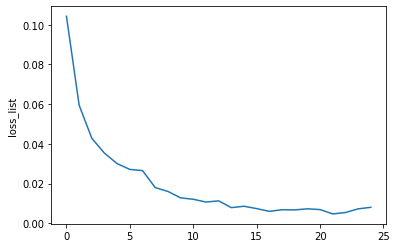

In [136]:
train_loss_list
train_acc_list
val_loss_list
val_acc_list 


plt.plot(train_loss_list)
plt.ylabel('loss_list')
plt.show()